<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique words in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique words in corpus: 17


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [6]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                        s["POS"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [9]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [10]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i,t, in enumerate(tags)}

In [11]:
word2idx

{'Marcell': 1,
 'inseparable': 2,
 'Winston': 3,
 'gift-giving': 4,
 'quest': 5,
 'mammals': 6,
 'Abdoulaye': 7,
 'FY08/09': 8,
 'four-tenths': 9,
 'neo-liberal': 10,
 'Massoud': 11,
 'north-south': 12,
 'interactive': 13,
 'partners': 14,
 'drunken': 15,
 'throughout': 16,
 'approximately': 17,
 'Rahama': 18,
 'Still': 19,
 'German-owned': 20,
 'Persian': 21,
 'chiefdoms': 22,
 'hills': 23,
 'taping': 24,
 'cousins': 25,
 '1784': 26,
 'Ekici': 27,
 'Dealing': 28,
 'Hikmet': 29,
 'installment': 30,
 'would': 31,
 'J.P.': 32,
 'able-bodied': 33,
 'Amar': 34,
 'choosing': 35,
 'strange': 36,
 'Sept.': 37,
 'Arafat-allies': 38,
 'Undercover': 39,
 'checks-and-balances': 40,
 'unitary': 41,
 'List': 42,
 'kicks': 43,
 'privilege': 44,
 'Darmawan': 45,
 'hunger': 46,
 'exiting': 47,
 'specified': 48,
 'uninterred': 49,
 'opposition-led': 50,
 'Markko': 51,
 'Sota': 52,
 'unforgivable': 53,
 'hails': 54,
 'Chrysostomos': 55,
 'Naha': 56,
 'revolutionary': 57,
 'Strasbourg': 58,
 '254': 59,
 

### Task 5: Padding Input Sentences and Creating Train/Test Splits

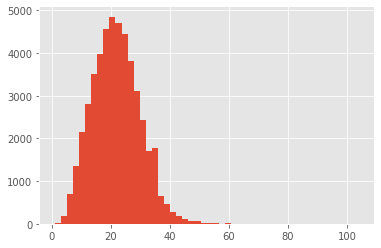

In [12]:
plt.hist([len(s) for s  in sentences], bins=50)
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences= X, padding='post',value = num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])
y = [to_categorical(i,num_classes=num_tags) for i in y]

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test , y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [15]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [16]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
             metrics =['accuracy'])

### Task 7: Train the Model

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

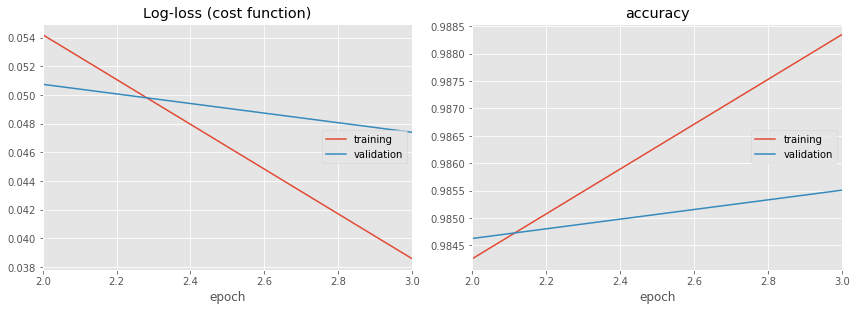

Log-loss (cost function):
training   (min:    0.039, max:    0.194, cur:    0.039)
validation (min:    0.047, max:    0.071, cur:    0.047)

accuracy:
training   (min:    0.956, max:    0.988, cur:    0.988)
validation (min:    0.980, max:    0.986, cur:    0.986)
34530/34530 [==============================] - 180s 5ms/sample - loss: 0.0386 - accuracy: 0.9883 - val_loss: 0.0474 - val_accuracy: 0.9855


In [19]:
early_stopping =  EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size =32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

### Task 8: Evaluate Named Entity Recognition Model

In [20]:
model.evaluate(x_test, np.array(y_test))

4796/4796 [==============================] - 5s 1ms/sample - loss: 0.0490 - accuracy: 0.9854


[0.04903287031657503, 0.9853878]

In [23]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-"*30)
for w, true, pred in zip(x_test[i],y_true, p[0]):
    print("(:15){}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
(:15)Model	O
(:15)education	O
(:15),	O
(:15)social	O
(:15),	O
(:15)and	O
(:15)environment	O
(:15)programs	O
(:15)are	O
(:15)underway	O
(:15)with	O
(:15)support	O
(:15)from	O
(:15)multilateral	O
(:15)development	O
(:15)organizations	O
(:15).	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
(:15)al-Arabiya	O
